In [25]:
!pip install lifetimes

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

In [28]:
df = pd.read_csv('/content/drive/MyDrive/Customer_Segmentation/RFM + CLTV/data.csv', encoding='latin1')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [29]:
df['InvoiceDate'] =  pd.to_datetime(df['InvoiceDate'])

In [30]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [32]:
df['Country'].value_counts().head()

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: Country, dtype: int64

In [33]:
uk = df[df['Country']=='United Kingdom']
uk['InvoiceDate'] =  pd.to_datetime(uk['InvoiceDate'])
uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [34]:
uk.shape

(495478, 8)

In [35]:
# Loai bo gia tri nan
uk = uk[uk['CustomerID'].notna()]
uk.shape

(361878, 8)

In [36]:
uk = uk[uk['Quantity'] > 0]
uk = uk[uk['UnitPrice'] > 0]
uk.head(5)
print(uk.shape)

(354321, 8)


In [37]:
def add_years_to_date(data, date_column, n):

    data[date_column] = pd.to_datetime(data[date_column])
    data[date_column] = data[date_column] + pd.DateOffset(years=n)
    return data


In [38]:
uk  = add_years_to_date(uk, 'InvoiceDate', 11)
uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2021-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2021-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2021-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2021-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2021-12-01 08:26:00,3.39,17850.0,United Kingdom


### Customer Lifetime Vale Calcualtion

In [39]:
uk["TotalPurchase"]=uk["Quantity"]*uk["UnitPrice"]
uk

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2021-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2021-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2021-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2021-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2021-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2022-12-09 12:31:00,1.95,15804.0,United Kingdom,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2022-12-09 12:49:00,2.95,13113.0,United Kingdom,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2022-12-09 12:49:00,1.25,13113.0,United Kingdom,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2022-12-09 12:49:00,8.95,13113.0,United Kingdom,214.80


### BG-NBD Model and Gammma-Gamma Model

In [40]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [41]:
today_date = datetime.today()
uk_cltv = uk.groupby('CustomerID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (today_date - pd.to_datetime(InvoiceDate).max()).days,
                         lambda InvoiceDate: (today_date - pd.to_datetime(InvoiceDate).min()).days],
         'InvoiceNo': lambda Invoice: Invoice.nunique(),
         'TotalPurchase': lambda TotalPrice: TotalPrice.sum()})
uk_cltv

InvoiceDate            InvoiceNo TotalPurchase
            <lambda_0> <lambda_1>  <lambda>      <lambda>
CustomerID                                               
12346.0            641        641         1      77183.60
12747.0            317        684        11       4196.01
12748.0            316        689       209      33719.73
12749.0            319        528         5       4090.88
12820.0            318        642         4        942.34
...                ...        ...       ...           ...
18280.0            593        593         1        180.60
18281.0            496        496         1         80.82
18282.0            323        442         2        178.05
18283.0            319        653        16       2094.88
18287.0            358        517         3       1837.28

[3920 rows x 4 columns]

In [42]:
uk_cltv.columns = ['recency', 'T', 'frequency', 'monetary']
uk_cltv.head()

,recency,T,frequency,monetary
CustomerID,,,,
12346.0,641,641,1,77183.60
12747.0,317,684,11,4196.01
12748.0,316,689,209,33719.73
12749.0,319,528,5,4090.88
12820.0,318,642,4,942.34


In [43]:
uk_cltv["monetary"] = uk_cltv["monetary"] / uk_cltv["frequency"]

#Calculate the frequency and recency values as weekly
uk_cltv["recency"] = uk_cltv["recency"] / 7
uk_cltv["T"] = uk_cltv["T"] / 7

#By definition, we choose customers greater than 1 frequency
uk_cltv = uk_cltv[(uk_cltv['frequency'] > 1)]

In [44]:
uk_cltv

,recency,T,frequency,monetary
CustomerID,,,,
12747.0,45.285714,97.714286,11,381.455455
12748.0,45.142857,98.428571,209,161.338421
12749.0,45.571429,75.428571,5,818.176000
12820.0,45.428571,91.714286,4,235.585000
12822.0,55.142857,57.571429,2,474.440000
...,...,...,...,...
18272.0,45.428571,80.285714,6,513.096667
18273.0,45.428571,81.857143,3,68.000000
18282.0,46.142857,63.142857,2,89.025000


In [45]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(uk_cltv['frequency'],uk_cltv['recency'], uk_cltv['T'])

<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 0.89, alpha: 11.69, b: 6.68, r: 1.27>

* Who are the 10 customers we expect the most to purchase in a week?

In [46]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        uk_cltv['frequency'],
                                                        uk_cltv['recency'],
                                                        uk_cltv['T']).sort_values(ascending=False).head(10)

CustomerID
17850.0    0.311541
17509.0    0.130623
13755.0    0.124733
14547.0    0.120116
15993.0    0.114811
18073.0    0.114527
18139.0    0.113087
15473.0    0.107479
17528.0    0.106790
13704.0    0.104275
dtype: float64

* Who are the 10 customers we expect the most to purchase in a month?

In [47]:
bgf.predict(4,uk_cltv['frequency'],uk_cltv['recency'],uk_cltv['T']).sort_values(ascending=False).head(10)


CustomerID
17850.0    1.233294
17509.0    0.515713
13755.0    0.492247
14547.0    0.474095
15993.0    0.453235
18073.0    0.452988
18139.0    0.446341
15473.0    0.424495
17528.0    0.421708
13704.0    0.411789
dtype: float64

In [48]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(uk_cltv['frequency'], uk_cltv['monetary'])


<lifetimes.GammaGammaFitter: fitted with 2570 subjects, p: 3.81, q: 0.34, v: 3.74>

In [49]:
ggf.conditional_expected_average_profit(uk_cltv['frequency'],
                                        uk_cltv['monetary']).sort_values(ascending=False).head(10)

CustomerID
16446.0    92172.269911
15749.0    15749.839803
15098.0    14116.862475
16000.0     4384.065816
18102.0     4340.137246
17450.0     4245.334862
14088.0     3936.402938
14096.0     3872.661442
17511.0     2954.022011
12931.0     2836.535733
dtype: float64

In [50]:
cltv = ggf.customer_lifetime_value(bgf,
                                       uk_cltv['frequency'],
                                       uk_cltv['recency'],
                                       uk_cltv['T'],
                                       uk_cltv['monetary'],
                                       time=6, # 6 months
                                       freq="W",  # The frequency information of t.
                                       discount_rate=0.01)

In [51]:
cltv = cltv.reset_index()
cltv_final = uk_cltv.merge(cltv, on="CustomerID", how="left")
cltv_final

,CustomerID,recency,T,frequency,monetary,clv
0,12747.0,45.285714,97.714286,11,381.455455,6.364218e+00
1,12748.0,45.142857,98.428571,209,161.338421,6.734037e-55
2,12749.0,45.571429,75.428571,5,818.176000,6.646805e+02
3,12820.0,45.428571,91.714286,4,235.585000,9.691013e+01
4,12822.0,55.142857,57.571429,2,474.440000,5.120532e+02
...,...,...,...,...,...,...
2565,18272.0,45.428571,80.285714,6,513.096667,2.862693e+02
2566,18273.0,45.428571,81.857143,3,68.000000,4.331479e+01
2567,18282.0,46.142857,63.142857,2,89.025000,8.094900e+01
2568,18283.0,45.571429,93.285714,16,130.930000,3.525201e-01


In [52]:
from sklearn.preprocessing import MinMaxScaler
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

In [53]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])
cltv_final.sort_values(by="scaled_clv", ascending=False).head(10)

,CustomerID,recency,T,frequency,monetary,clv,scaled_clv
1699,16446.0,45.142857,74.428571,2,84236.250000,57483.280931,1.000000
1072,15098.0,71.000000,71.000000,3,13305.500000,15611.899939,0.271590
1366,15749.0,78.714286,92.571429,3,14844.766667,12980.709490,0.225817
589,14096.0,45.571429,59.571429,17,3833.222941,7135.023262,0.124123
1485,16000.0,45.428571,45.428571,3,4131.233333,6836.237279,0.118926
2499,18139.0,47.571429,47.714286,6,1406.390000,3727.387826,0.064843
2212,17509.0,53.285714,54.142857,8,764.392500,2327.891617,0.040497
1954,16984.0,57.714286,63.571429,2,2240.675000,2189.792174,0.038094
1384,15786.0,51.714286,61.428571,3,1644.066667,2009.711395,0.034962
1604,16240.0,48.428571,56.142857,2,1859.400000,1967.839644,0.034233


In [54]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.sort_values(by="scaled_clv", ascending=False)

,CustomerID,recency,T,frequency,monetary,clv,scaled_clv,segment
1699,16446.0,45.142857,74.428571,2,84236.250000,5.748328e+04,1.000000e+00,A
1072,15098.0,71.000000,71.000000,3,13305.500000,1.561190e+04,2.715903e-01,A
1366,15749.0,78.714286,92.571429,3,14844.766667,1.298071e+04,2.258171e-01,A
589,14096.0,45.571429,59.571429,17,3833.222941,7.135023e+03,1.241235e-01,A
1485,16000.0,45.428571,45.428571,3,4131.233333,6.836237e+03,1.189257e-01,A
...,...,...,...,...,...,...,...,...
1173,15311.0,45.142857,98.428571,91,667.779121,4.374195e-21,7.609508e-26,D
842,14606.0,45.142857,98.285714,93,130.716667,2.691332e-22,4.681939e-27,D
133,13089.0,45.428571,97.857143,97,606.451856,2.327594e-22,4.049167e-27,D
2377,17841.0,45.285714,98.285714,124,330.577177,2.102936e-30,3.658345e-35,D


<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

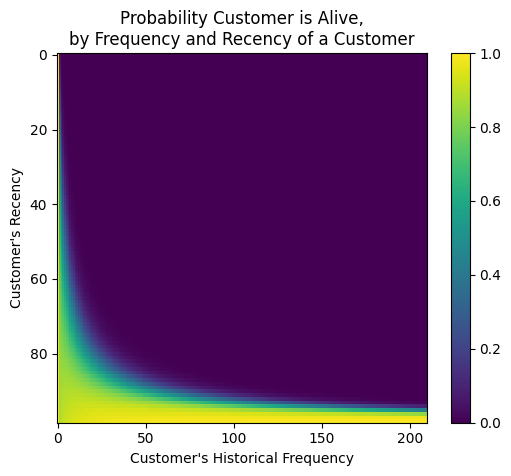

In [55]:
plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

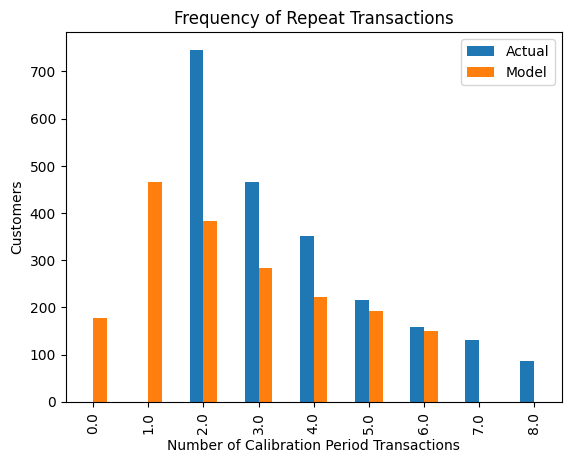

In [56]:
plot_period_transactions(bgf)